- competition/dataset : [Titanic - Machine Learning from Disaster](https://www.kaggle.com/c/titanic)
- date : 2021/01/22
- original : [https://www.kaggle.com/arthurtok/introduction-to-ensembling-stacking-in-python](https://www.kaggle.com/arthurtok/introduction-to-ensembling-stacking-in-python)

## Introduction to Ensemble/Stacking in Python

**✏ 필사 1회** 

### 1. Introdution
이 노트북은 기초 학습 모델 중 특히 스태킹 앙상블이라는 변형 모델을 결합하는 방법에 대해 소개한 기초적이고 간단한 입문용 노트북입니다. 간단히 말하면, 스태킹은 1단계로 사용하며, 몇 개의 기본적인 분류기를 통한 예측 후, 2단계에서 다른 모델을 사용하여 1단계 예측들로부터 나온 결과물을 예측합니다.  

Kaggle을 처음 접한 사람들이 타이타닉 데이터 셋에서 시작하기 때문에 이 개념을 도입하기에 가장 적합합니다. 또한 스태킹은 많은 팀들이 Kaggle 대회에서 우승하는데 한몫 했지만 이에 대한 커널은 부족한 것 같아, 이 노트북이 어느정도 공백을 메울 수 있기를 바랍니다.  

Faron은 회귀자의 앙상블을 사용하고, 여기서는 분류자의 앙상블을 사용했지만, 노트북 내의 자료들은 [Faron의 코드](https://www.kaggle.com/mmueller/stacking-starter)를 많이 따랐습니다.  

노트북이 어느정도 직관적이고 간결하게 앙상블의 개념을 전달할 수 있기를 바랍니다. 

In [1]:
# 라이브러리 로딩
import pandas as pd
import numpy as np
import re
import sklearn
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

# stacking에 5개의 기본 모델 사용
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier,
                              GradientBoostingClassifier, ExtraTreesClassifier)
from sklearn.svm import SVC
from sklearn.model_selection import KFold

import warnings
warnings.filterwarnings('ignore')

### 2. Feature Exploration, Engineering and Cleansing
지금부터 대부분의 커널들이 일반적으로 구성된 것과 비슷하게 진행할 것입니다. 먼저 가지고 있는 데이터를 탐색하고, 범주형 변수들을 수치형으로 바꿀 뿐만 아니라 가능한 feature engineering들에 대해 식별할 것입니다.

In [2]:
# 데이터 로딩
train = pd.read_csv('../data/titanic_train.csv')
test = pd.read_csv('../data/titanic_test.csv')

# 접근하기 쉽도록 passengerId 저장
PassengerId = test['PassengerId']

In [3]:
train.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


우리가 해야 할 일은 범주형 변수로부터 정보를 추출하는 것입니다.

#### Feature Engineering
여기서는 [Sina의 노트북](https://www.kaggle.com/sinakhorami/titanic-best-working-classifier)을 참고하여 feature engineering을 진행하겠습니다.

In [4]:
full_data = [train, test]

# 승객의 이름 길이 저장
train['Name_length'] = train['Name'].apply(len)
test['Name_length'] = test['Name'].apply(len)

In [5]:
# 승객의 객실 유무
train['Has_Cabin'] = train['Cabin'].apply(lambda x: 0 if type(x) == float else 1)
test['Has_Cabin'] = test['Cabin'].apply(lambda x: 0 if type(x) == float else 1)

In [6]:
# FamilySize 컬럼 생성
for dataset in full_data:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1

In [7]:
# IsAlone 컬럼 생성
for dataset in full_data:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1

In [8]:
# Embarked 컬럼의 결측값 제거
for dataset in full_data:
    dataset['Embarked'].fillna('S', inplace=True)

In [9]:
# Fare 컬럼의 결측값 제거 및 CategoricalFare 컬럼 생성
for dataset in full_data:
    dataset['Fare'].fillna(train['Fare'].median(), inplace=True)
train['CategoricalFare'] = pd.qcut(train['Fare'], 4)

In [10]:
# CategoricalAge 컬럼 생성
for dataset in full_data:
    age_avg = dataset['Age'].mean()
    age_std = dataset['Age'].std()
    age_null_count = dataset['Age'].isnull().sum()
    age_null_random_list = np.random.randint(age_avg-age_std, age_avg+age_std, size=age_null_count)
    dataset['Age'][np.isnan(dataset['Age'])] = age_null_random_list
    dataset['Age'] = dataset['Age'].astype(int)
train['CategoricalAge'] = pd.cut(train['Age'], 5)

In [11]:
# 승객 이름에서 title만 추출하는 함수 정의
def get_title(name):
    title_search = re.search('([A-Za-z]+)\.', name)
    # title이 있으면 추출
    if title_search:
        return title_search.group(1)
    return ''

# Title 컬럼 생성
for dataset in full_data:
    dataset['Title'] = dataset['Name'].apply(get_title)

# 공통적이지 않은 title은 Rare로 그룹화
for dataset in full_data:
    dataset['Title'] = dataset['Title'].replace([
        'Lady', 'Countess', 'Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'
    ], 'Rare')
    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

In [12]:
# 범주형 변수 매핑
for dataset in full_data:
    # Sex
    dataset['Sex'] = dataset['Sex'].map({'female':0, 'male':1}).astype(int)
    # Title
    dataset['Title'] = dataset['Title'].map({'Mr':1, 'Miss':2, 'Mrs':3, 'Master':4, 'Rare':5})
    # Embarked
    dataset['Embarked'] = dataset['Embarked'].map({'S':0, 'C':1, 'Q':2}).astype(int)
    # Fare
    dataset.loc[dataset['Fare'] <= 7.91, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91)&(dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454)&(dataset['Fare'] <= 31), 'Fare'] = 2
    dataset.loc[dataset['Fare'] > 31, 'Fare'] = 3
    # Age
    dataset.loc[dataset['Age'] <= 16, 'Age'] = 0
    dataset.loc[(dataset['Age'] > 16)&(dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32)&(dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48)&(dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[dataset['Age'] > 64, 'Age'] = 4;

In [13]:
# Feature 선택
drop_elements = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp']
train.drop(drop_elements, axis=1, inplace=True)
train.drop(['CategoricalAge', 'CategoricalFare'], axis=1, inplace=True)
test.drop(drop_elements, axis=1, inplace=True)

이제 feature 정제와 관련 정보 추출을 마쳤고, 범주형 컬럼까지 제거했으므로 모든 feature가 머신러닝 모델에 적합한 형태인 숫자형 변수여야 합니다. 그러나 진행하기 앞서 변환한 데이터의 상관관계와 분포를 시각화해봅시다.

### 3. Visualizations

In [14]:
train.head(3)

,Survived,Pclass,Sex,Age,Parch,Fare,Embarked,Name_length,Has_Cabin,FamilySize,IsAlone,Title
0,0,3,1,1,0,0.0,0,23,0,2,0,1
1,1,1,0,2,0,3.0,1,51,1,2,0,3
2,1,3,0,1,0,1.0,0,22,0,1,1,2


#### Pearson Correlation Heatmap
feature 간의 상관관계를 보기 위해 상관관계 플롯을 만들어 보겠습니다. Seaborn 시각화 패키지를 활용하여 다음과 같이 편리하게 히트맵을 나타낼 수 있습니다.

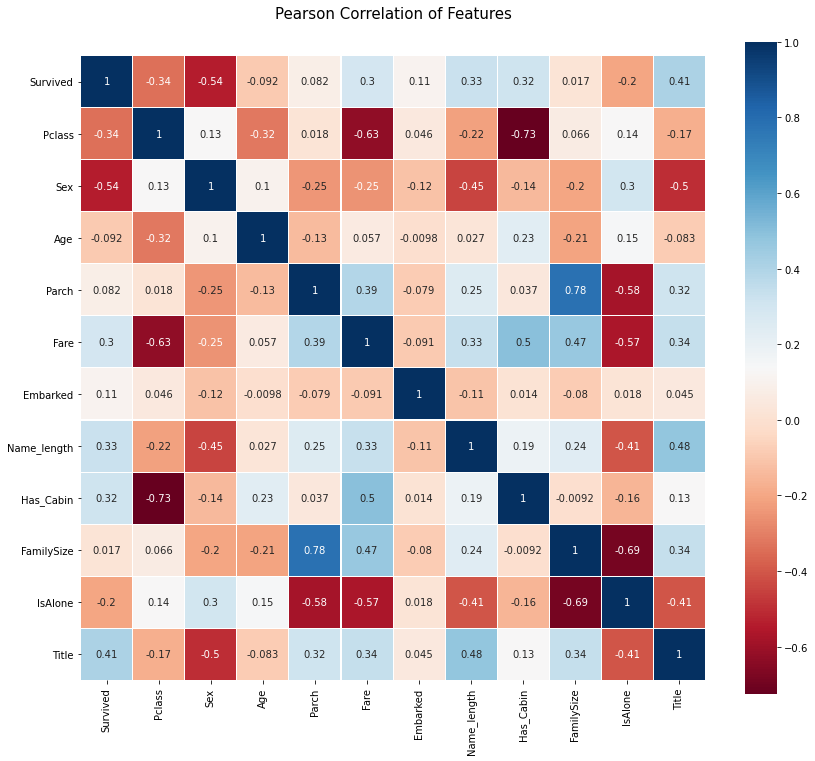

In [15]:
plt.figure(figsize=(14, 12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(train.astype(float).corr(), linewidths=0.1, vmax=1.0,
           square=True, annot=True, cmap='RdBu', linecolor='white')
plt.show()

#### Takeaway from the Plots
피어슨 상관관계 플롯을 보면 강한 상관관계를 갖는 플롯이 많지 않다는 것을 알 수 있습니다. 이는 트레이닝 셋에 불필요한 데이터가 없음을 의미하기 때문에 학습모델에 해당 feature들을 사용하려는 점에서 유용합니다.또한 각각의 feature들이 독특한 정보들을 준다는 점에서 기쁩니다. 가장 상관관계가 있는 두 feature는 FamilySize와 Parch입니다. 이 연습의 목적을 위해 두 변수를 그대로 두겠습니다.

#### Pairplots
데이터의 분포를 알아보기 위해 pairplot을 그려보겠습니다. 다시 한번 Seborn을 사용할 것입니다.

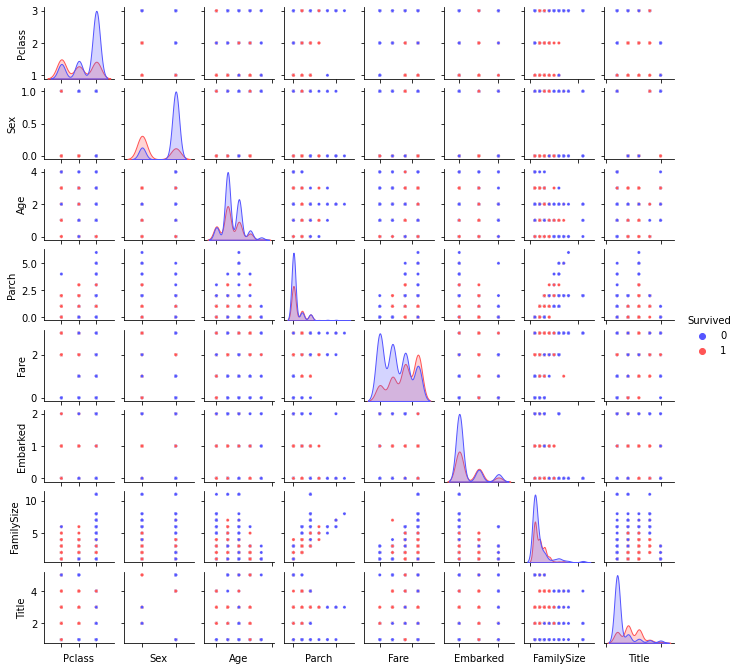

In [16]:
g = sns.pairplot(train[['Survived', 'Pclass', 'Sex', 'Age', 'Parch', 'Fare', 'Embarked', 'FamilySize', 'Title']],
                hue='Survived', palette='seismic', size=1.2, diag_kind='kde', diag_kws=dict(shade=True), plot_kws=dict(s=10))
g.set(xticklabels=[])

### 4. Ensembling & Stacking models
feature engineering과 formatting을 빠르게 지나왔고, 이제 이 노트북의 핵심 파트로 왔습니다. 스태킹 앙상블을 만들어봅시다.

#### Helpers via Python Classes
좀더 편하게 작업하기 위해 몇 가지 파이썬의 클래스들을 호출합니다. 클래스는 객체 지향 프로그래밍과 함께 사용됩니다. 즉, 클래스는 객체를 생성하기 위한 코드나 프로그램을 확장하는데 도움이 되며, 해당 클래스에 함수와 메소드를 구현합니다.  

다음 코드는 모든 Sklearn 분류기에 공통적으로 내장된 함수를 확장할 수 있게 하는 SklearnHelper 클래스에 대한 내용입니다. 

In [17]:
ntrain = train.shape[0]
ntest = test.shape[0]
SEED = 0
NFOLDS = 5
kf = KFold(n_splits=NFOLDS, random_state=SEED)

# Sklearn 분류기를 확장하기 위한 클래스
class SklearnHelper(object):
    def __init__(self, clf, seed=0, params=None):
        params['random_state'] = seed
        self.clf = clf(**params)
    
    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)
    
    def predict(self, x):
        return self.clf.predict(x)
    
    def fit(self, x, y):
        return self.clf.fit(x, y)
    
    def feature_importances(self, x, y):
        print(self.clf.fit(x, y).feature_importances_)

파이썬에서 클래스나 객체를 만들어본 적이 없는 사람들을 위해 위에 주어진 코드를 설명해보려 합니다. 기본 분류기를 만들 때 오로지 Sklearn 라이브러리에 있는 모델만 사용할 것이고, 따라서 그것에 대한 클래스만 확장할 것입니다.  

**def init:**  
클래서 기본 생성자를 호출하기 위한 파이썬의 표준입니다. 객체(분류기)를 만들고자 할 때, clf(sklearn의 분류기), seed(random seed), params(분류기의 파라미터)를 입력해야 합니다.  

나머지 코드들은 상응하는 sklearn 분류기 내부의 메소드를 호출하는 단순한 메소드들입니다. 근본적으로 다양한 Sklearn 분류기들을 확장하여 스태커에 다양한 학습자들을 구현할 때 같은 코드를 계속 반복해서 작성하는 작업을 줄이기 위해 만든 wrapper 클래스입니다.

#### Out-of-Fold Predictions
도입 부분에서 언급했던 것처럼, 스태킹은 2단계 모델을 학습하기 위한 input으로 기본 분류기들의 예측을 사용합니다. 그러나 단순히 트레이닝 데이터 전체에 대한 기본 모델을 학습하고 전체 테스트 셋에 대한 예측을 생성한 후 2단계 훈련을 위해 모델들을 출력할 수는 없습니다. 이미 기본 모델의 예측에 테스트 셋을 봤을 때, 이 예측을 제공하면 과적합될 위험이 있습니다.  

*numpy.zeros와 달리 numpy.empty는 어레이의 값들을 0으로 초기화하지 않아서 더 빠름

In [18]:
def get_oof(clf, x_train, y_train, x_test):
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))
    oof_test_skf = np.empty((NFOLDS, ntest))
    
    for i, (train_index, test_index) in enumerate(kf.split(x_train)):
        x_tr = x_train[train_index]
        y_tr = y_train[train_index]
        x_te = x_train[test_index]
        
        clf.train(x_tr, y_tr)
        
        oof_train[test_index] = clf.predict(x_te)
        oof_test_skf[i, :] = clf.predict(x_test)
    
    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)

### 5. Generating our Base First-Level Models
우리의 1단계 분류에 사용할 다섯 개의 학습 모델들을 준비해봅시다. 이 모델들은 Sklearn 라이브러리를 통해 쉽게 호출할 수 있습니다.  

1. Random Forest classifier (랜덤포레스트)
2. Extra Trees classifier (익스트림랜덤트리)
3. AdaBoost classifier (에이다부스트)
4. Gradient Boosting classifier (그레디언트부스팅)
5. Support Vector Machine (서포트벡터머신)

#### Parameters
**n_jobs**: 훈련 과정에서 사용될 코어의 개수, -1로 설정 시 모든 코어 사용  
**n_estimators**: 학습 모델의 분류 트리 개수, 기본값은 10  
**max_depth**: 트리의 최대 깊이, 또는 확장해야 하는 노드의 크기, 너무 높은 값으로 설정하면 트리의 깊이가 너무 깊어지기 때문에 과적합될 위험이 있음  
**verbose**: 학습 과정에 대한 텍스트 결과 출력을 조절, 0은 텍스트 출력x, 3은 모든 반복에 트리 학습 절차가 출력됨  

자세한 사항은 [Sklearn 사이트](https://scikit-learn.org/stable/)를 참조하세요.

In [19]:
# 파라미터 입력
# Random Forest 파라미터
rf_params = {
    'n_jobs':-1,
    'n_estimators':500, 
    'warm_start':True,
#     'max_features':0.2,
    'max_depth':6,
    'min_samples_leaf':2,
    'max_features':'sqrt',
    'verbose':0
}
# Extra Trees 파라미터
et_params = {
    'n_jobs':-1,
    'n_estimators':500,
#     'max_fatures':0.5,
    'max_depth':8,
    'min_samples_leaf':2,
    'verbose':0
}
# AdaBoost 파라미터
ada_params = {
    'n_estimators':500,
    'learning_rate':0.75
}
# Gradient Boosting 파라미터
gb_params = {
    'n_estimators':500,
#     'max_features':0.2,
    'max_depth':5,
    'min_samples_leaf':2,
    'verbose':0
}
# Support Vector Classifier 파라미터
svc_params = {
    'kernel':'linear',
    'C':0.025
}

OOP 프레임워크 내 객체와 클래스에 대해서 언급했기 때문에, 이제 사전에 정의한 SklearnHelper 클래스를 통해 5개의 학습 모델들을 나타내는 5개의 객체를 만들어봅시다.

In [20]:
# 5개의 모델들을 나타내는 5개의 객체 생성
rf = SklearnHelper(clf=RandomForestClassifier, seed=SEED, params=rf_params)
et = SklearnHelper(clf=ExtraTreesClassifier, seed=SEED, params=et_params)
ada = SklearnHelper(clf=AdaBoostClassifier, seed=SEED, params=ada_params)
gb = SklearnHelper(clf=GradientBoostingClassifier, seed=SEED, params=gb_params)
svc = SklearnHelper(clf=SVC, seed=SEED, params=svc_params)

#### Creating NumPy arrays out of our train and test sets
첫 번째 기본 모델 층을 만들었습니다. 이제 원래 데이터프레임에서 NumPy array를 만들어 분류기에 입력할 트레이닝 데이터와 테스트 데이터를 준비할 수 있습니다.  

*배열.ravel() : 다차원 배열을 1차원 배열로 변환

In [21]:
# 모델에 입력할 트레이닝, 테스트, 타겟 데이터의 NumPy array 생성
y_train = train['Survived'].ravel()
train.drop(['Survived'], axis=1, inplace=True)
x_train = train.values
x_test = test.values

#### Output of the First level Predictions
5개의 기본 분류기에 트레이닝 데이터와 테스트 데이터를 입력하고, 1단계 예측을 만들기 위해 앞에서 정의했던 Out-of-Fold 예측 함수를 사용하겠습니다. 다음 코드는 실행되는데 시간이 조금 걸립니다.

In [22]:
# OOF 트레이닝, 테스트 예측 생성
# Extra Trees
et_oof_train, et_oof_test = get_oof(et, x_train, y_train, x_test)
# Random Forest
rf_oof_train, rf_oof_test = get_oof(rf, x_train, y_train, x_test)
# AdaBoost
ada_oof_train, ada_oof_test = get_oof(ada, x_train, y_train, x_test)
# Gradient Boost
gb_oof_train, gb_oof_test = get_oof(gb, x_train, y_train, x_test)
# Support Vector Classifier
svc_oof_train, svc_oof_test = get_oof(svc, x_train, y_train, x_test)

print('Training is complete')

Training is complete


#### Feature importances generated from the different classifiers
1단계 분류기를 학습시켰으니 이제 Sklearn 모델들의 훌륭한 기능들을 활용할 수 있습니다. 바로 매우 간단한 코드로 트레이닝 셋과 테스트 셋의 다양한 feature들에 대한 중요도를 확인하는 것입니다.  

Sklearn 문서에 따르면, 대부분의 분류기들은 **.feature_importances_**를 입력하기만 하면 feature의 중요도를 리턴하는 속성이 내장되어 있습니다. 따라서 우리는 앞에서 만든 함수를 통해 이 속성을 호출하고 feature 중요도를 나타내보겠습니다.

In [23]:
rf_feature = rf.feature_importances(x_train, y_train)
et_feature = et.feature_importances(x_train, y_train)
ada_feature = ada.feature_importances(x_train, y_train)
gb_feature = gb.feature_importances(x_train, y_train)

[0.12446331 0.19814024 0.03765721 0.02032334 0.0703032  0.02311799
 0.10744029 0.06594793 0.06851343 0.01286843 0.27122462]
[0.12017516 0.38058536 0.03626579 0.01612607 0.05505626 0.02815085
 0.0460034  0.08312139 0.04396092 0.02083904 0.16971577]
[0.032 0.01  0.016 0.068 0.034 0.008 0.7   0.012 0.05  0.004 0.066]
[0.08613671 0.00991629 0.05641188 0.01353884 0.05486123 0.0228535
 0.17553865 0.03467532 0.11094762 0.00745478 0.42766519]


feature 중요도를 할당하고 저장하는 방법을 아직 파악하지 못했기 때문에 위의 코드에서 값을 출력한 후 다음 Python 목록에 붙여넣겠습니다.

In [24]:
rf_features = [0.12444684, 0.1992726, 0.03415395, 0.02061815, 0.07210196, 0.02259669, 0.1075789, 0.06552609, 0.06910728, 0.01359387, 0.27100368]
et_features = [0.1178221, 0.37824429, 0.03105153, 0.01750477, 0.05532562, 0.02873246, 0.04724392, 0.08393697, 0.04464622, 0.02168516, 0.17380696]
ada_features = [0.032, 0.014, 0.016, 0.068, 0.04, 0.008, 0.686, 0.014, 0.05, 0.004, 0.068]
gb_features = [0.08634036, 0.01222881, 0.04897444, 0.01496732, 0.05301311, 0.0228918, 0.1776066, 0.03744085, 0.11033338, 0.00676652, 0.42943679]

Plotly 패키지를 통해 쉽게 시각화시키기 위해 위의 리스트로 데이터프레임을 만듭니다.

In [25]:
cols = train.columns.values
feature_dataframe = pd.DataFrame({
    'features':cols,
    'Random Forest feature importances':rf_features,
    'Extra Trees feature importances':et_features,
    'AdaBoost feature importances':ada_features,
    'Gradient Boost feature importances':gb_features
})

#### Interactive feature importances via Plotly scatterplots
이 시점에서 대화형 Plotly 패키지를 사용하겠습니다. 'Scatter'를 호출하여 다양한 분류기들의 feature 중요도 값을 산점도를 통해 시각화해봅시다.

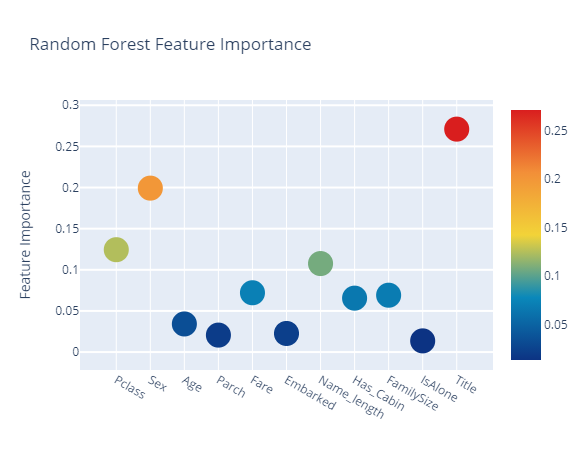

In [26]:
# Random Forest
trace = go.Scatter(
    y=feature_dataframe['Random Forest feature importances'].values,
    x=feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode='diameter',
        sizeref=1,
        size=25,
        color=feature_dataframe['Random Forest feature importances'].values,
        colorscale='Portland',
        showscale=True),
    text=feature_dataframe['features'].values
)
layout = go.Layout(
    autosize=True,
    title='Random Forest Feature Importance',
    hovermode='closest',
    yaxis=dict(
        title='Feature Importance',
        ticklen=5,
        gridwidth=2),
    showlegend=False
)
fig = go.Figure(data=[trace], layout=layout)
py.iplot(fig, filename='scatter2010')

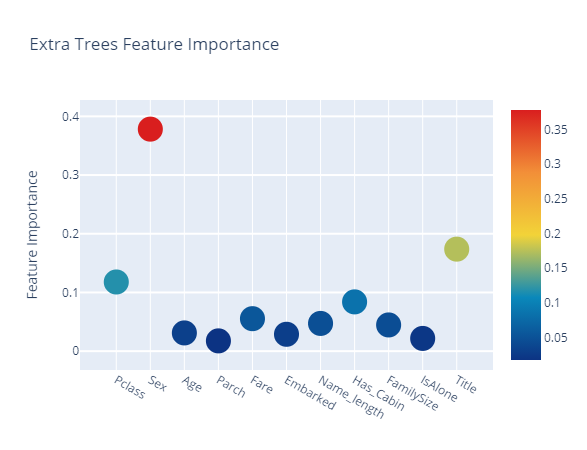

In [27]:
# Extra Trees
trace = go.Scatter(
    y=feature_dataframe['Extra Trees feature importances'].values,
    x=feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode='diameter',
        sizeref=1,
        size=25,
        color=feature_dataframe['Extra Trees feature importances'].values,
        colorscale='Portland',
        showscale=True),
    text=feature_dataframe['features'].values
)
layout = go.Layout(
    autosize=True,
    title='Extra Trees Feature Importance',
    hovermode='closest',
    yaxis=dict(
        title='Feature Importance',
        ticklen=5,
        gridwidth=2),
    showlegend=False
)
fig = go.Figure(data=[trace], layout=layout)
py.iplot(fig, filename='scatter2010')

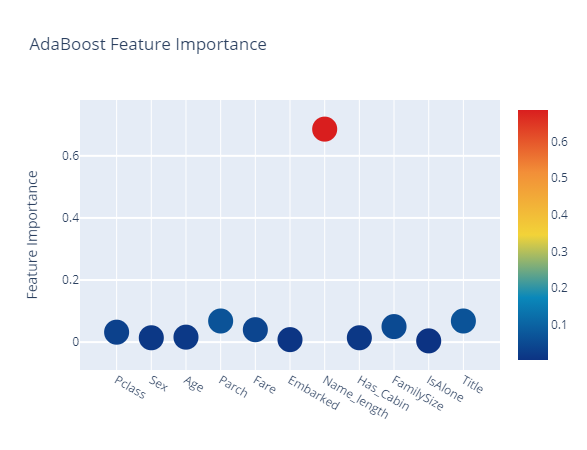

In [28]:
# AdaBoost
trace = go.Scatter(
    y=feature_dataframe['AdaBoost feature importances'].values,
    x=feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode='diameter',
        sizeref=1,
        size=25,
        color=feature_dataframe['AdaBoost feature importances'].values,
        colorscale='Portland',
        showscale=True),
    text=feature_dataframe['features'].values
)
layout = go.Layout(
    autosize=True,
    title='AdaBoost Feature Importance',
    hovermode='closest',
    yaxis=dict(
        title='Feature Importance',
        ticklen=5,
        gridwidth=2),
    showlegend=False
)
fig = go.Figure(data=[trace], layout=layout)
py.iplot(fig, filename='scatter2010')

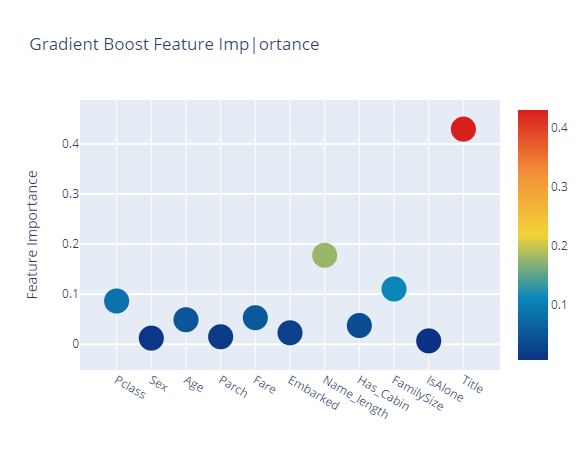

In [29]:
# Gradient Boost
trace = go.Scatter(
    y=feature_dataframe['Gradient Boost feature importances'].values,
    x=feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode='diameter',
        sizeref=1,
        size=25,
        color=feature_dataframe['Gradient Boost feature importances'].values,
        colorscale='Portland',
        showscale=True),
    text=feature_dataframe['features'].values
)
layout = go.Layout(
    autosize=True,
    title='Gradient Boost Feature Imp|ortance',
    hovermode='closest',
    yaxis=dict(
        title='Feature Importance',
        ticklen=5,
        gridwidth=2),
    showlegend=False
)
fig = go.Figure(data=[trace], layout=layout)
py.iplot(fig, filename='scatter2010')

모든feature 중요도의평균을 계산하고 feature importance 데이터프레임의 새로운 컬럼에 저장해보겠습니다.

In [30]:
# 평균값 컬럼 생성
feature_dataframe['mean'] = feature_dataframe.mean(axis=1)
feature_dataframe.head(3)

,features,Random Forest feature importances,Extra Trees feature importances,AdaBoost feature importances,Gradient Boost feature importances,mean
0,Pclass,0.124447,0.117822,0.032,0.086340,0.090152
1,Sex,0.199273,0.378244,0.014,0.012229,0.150936
2,Age,0.034154,0.031052,0.016,0.048974,0.032545


#### Plotly Barplot of Average Feature Importances
모든 분류기들의 평균 feature 중요도를 얻음으로써 다음과 같이 막대그래프로 나타낼 수 있습니다.

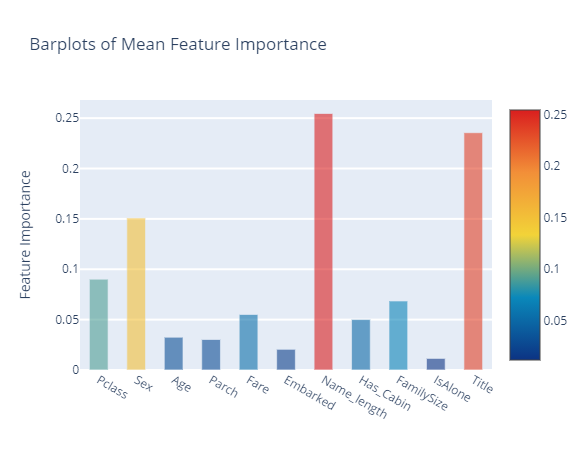

In [31]:
x = feature_dataframe['features'].values
y = feature_dataframe['mean'].values
data = [go.Bar(
    x=x, y=y, width=0.5,
    marker=dict(
        color=feature_dataframe['mean'].values,
        colorscale='Portland',
        showscale=True,
        reversescale=False),
    opacity=0.6
)]
layout = go.Layout(
    autosize=True,
    title='Barplots of Mean Feature Importance',
    hovermode='closest',
    yaxis=dict(
        title='Feature Importance',
        ticklen=5,
        gridwidth=2),
    showlegend=False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='bar-direct-labels')

### 6. Second-Level Predictions from the First-level Output

#### First-level output as new features
1단계 예측을 얻었으므로 그것이 본질적으로 다음 분류기의 트레이닝 데이터로 사용될 새로운 feature 셋이라고 생각할 수 있습니다. 다음 코드를 따라 1단계 예측에 대한 새로운 컬럼을 만들고 다음 분류기에 학습시킵니다.

In [32]:
base_predictions_train = pd.DataFrame({
    'RandomForest':rf_oof_train.ravel(),
    'ExtraTrees':et_oof_train.ravel(),
    'AdaBoost':ada_oof_train.ravel(),
    'GradientBoost':gb_oof_train.ravel()
})
base_predictions_train.head(3)

,RandomForest,ExtraTrees,AdaBoost,GradientBoost
0,0.0,0.0,0.0,0.0
1,1.0,1.0,1.0,1.0
2,0.0,0.0,1.0,1.0


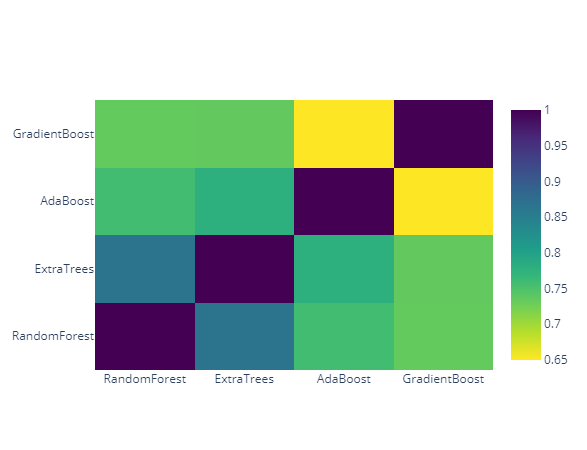

In [33]:
data = [go.Heatmap(
    z=base_predictions_train.astype(float).corr().values,
    x=base_predictions_train.columns.values,
    y=base_predictions_train.columns.values,
    colorscale='Viridis',
    showscale=True,
    reversescale=True
)]
py.iplot(data, filename='labelled-heatmap')

서로 관련이 없는 훈련된 모델들로 더 좋은 점수를 얻을 수 있다는 점에 대한 이야기가 많습니다. 

In [34]:
x_train = np.concatenate((et_oof_train, rf_oof_train, ada_oof_train, gb_oof_train, svc_oof_train), axis=1)
x_test = np.concatenate((et_oof_test, rf_oof_test, ada_oof_test, gb_oof_test, svc_oof_test), axis=1)

1단계 트레이닝과 테스트 예측을 x_train과 x_test에 연결하였고, 이제 2단계 학습 모델을 다뤄봅시다.

#### Second level learning model via XGBoost
상향된 트리 학습 모델을 위해 XGBoost 라이브러리를 사용합니다. 이것은 큰 규모의 상향된 트리 알고리즘을 최적화하기 위해 생성되었습니다. 해당 알고리즘에 대한 정보는 [문서](https://xgboost.readthedocs.io/en/latest/)를 통해 확인하십시오.

In [35]:
gbm = xgb.XGBClassifier(
    n_estimators=2000,
    max_depth=4,
    min_child_weight=2,
    gamma=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='binary:logistic',
    nthread=-1,
    scale_pos_weight=1
).fit(x_train, y_train)
predictions = gbm.predict(x_test)

[14:39:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


**max_dapth**: 트리의 깊이, 너무 큰 값은 과적합 가능성이 있음  
**gamma**: 트리의 leaf 노드에 추가 파티션을 만드는 데 필요한 최소 손실 감소, 값이 클수록 알고리즘의 보수성이 올라감  
**eta**: 과적합 방지를 위해 각 부스팅 단계에서 사용되는 step 크기 축소

#### Producing the submission file
1단계와 2단계 모델 모두 훈련과 학습을 마쳤습니다. 이제 타이타닉 대회에 제출하기 위한 적절한 형식으로 예측을 출력할 수 있습니다.

In [36]:
StackingSubmission = pd.DataFrame({
    'PassengerId':PassengerId,
    'Survived':predictions
})
StackingSubmission.to_csv('../data/titanic_4_submission.csv', index=False)

## Introduction to Ensemble/Stacking in Python

**✏ 필사 2회** 

### 1. Introdution
이 노트북은 기초 학습 모델 중 특히 스태킹 앙상블이라는 변형 모델을 결합하는 방법에 대해 소개한 기초적이고 간단한 입문용 노트북입니다. 간단히 말하면, 스태킹은 1단계로 사용하며, 몇 개의 기본적인 분류기를 통한 예측 후, 2단계에서 다른 모델을 사용하여 1단계 예측들로부터 나온 결과물을 예측합니다.  

Kaggle을 처음 접한 사람들이 타이타닉 데이터 셋에서 시작하기 때문에 이 개념을 도입하기에 가장 적합합니다. 또한 스태킹은 많은 팀들이 Kaggle 대회에서 우승하는데 한몫 했지만 이에 대한 커널은 부족한 것 같아, 이 노트북이 어느정도 공백을 메울 수 있기를 바랍니다.  

Faron은 회귀자의 앙상블을 사용하고, 여기서는 분류자의 앙상블을 사용했지만, 노트북 내의 자료들은 [Faron의 코드](https://www.kaggle.com/mmueller/stacking-starter)를 많이 따랐습니다.  

노트북이 어느정도 직관적이고 간결하게 앙상블의 개념을 전달할 수 있기를 바랍니다. 

In [2]:
# 라이브러리 로딩
import pandas as pd
import numpy as np
import re
import sklearn
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

# stacking에 5개의 기본 모델 사용
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier,
                              GradientBoostingClassifier, ExtraTreesClassifier)
from sklearn.svm import SVC
from sklearn.model_selection import KFold

import warnings
warnings.filterwarnings('ignore')

### 2. Feature Exploration, Engineering and Cleansing
지금부터 대부분의 커널들이 일반적으로 구성된 것과 비슷하게 진행할 것입니다. 먼저 가지고 있는 데이터를 탐색하고, 범주형 변수들을 수치형으로 바꿀 뿐만 아니라 가능한 feature engineering들에 대해 식별할 것입니다.

In [3]:
# 데이터 로딩
train = pd.read_csv('../data/titanic_train.csv')
test = pd.read_csv('../data/titanic_test.csv')

# 접근하기 쉽도록 passengerId 저장
PassengerId = test['PassengerId']

In [4]:
train.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


우리가 해야 할 일은 범주형 변수로부터 정보를 추출하는 것입니다.

#### Feature Engineering
여기서는 [Sina의 노트북](https://www.kaggle.com/sinakhorami/titanic-best-working-classifier)을 참고하여 feature engineering을 진행하겠습니다.

In [5]:
full_data = [train, test]

# 승객의 이름 길이 저장
train['Name_length'] = train['Name'].apply(len)
test['Name_length'] = test['Name'].apply(len)

In [6]:
# 승객의 객실 유무
train['Has_Cabin'] = train['Cabin'].apply(lambda x: 0 if type(x) == float else 1)
test['Has_Cabin'] = test['Cabin'].apply(lambda x: 0 if type(x) == float else 1)

In [7]:
# Family Size 컬럼 생성
for dataset in full_data:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1

In [8]:
# IsAlone 컬럼 생성
for dataset in full_data:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1

In [9]:
# Embarked 컬럼의 결측값 제거
for dataset in full_data:
    dataset['Embarked'].fillna('S', inplace=True)

In [10]:
# Fare 컬럼의 결측값 제거 및 CategoricalFare 컬럼 생성
for dataset in full_data:
    dataset['Fare'].fillna(train['Fare'].median(), inplace=True)
train['CategoricalFare'] = pd.qcut(train['Fare'], 4)

In [11]:
# CategoricalAge 컬럼 생성
for dataset in full_data:
    age_avg = dataset['Age'].mean()
    age_std = dataset['Age'].std()
    age_null_count = dataset['Age'].isnull().sum()
    age_null_random_list = np.random.randint(age_avg-age_std, age_avg+age_std, size=age_null_count)
    dataset['Age'][np.isnan(dataset['Age'])] = age_null_random_list
    dataset['Age'] = dataset['Age'].astype(int)
train['CategoricalAge'] = pd.cut(train['Age'], 5)

In [12]:
# 승객 이름에서 title만 추출하는 함수 정의
def get_title(name):
    title_search = re.search('([A-Za-z]+)\.', name)
    # title이 있으면 추출
    if title_search:
        return title_search.group(1)
    return ''

# Title 컬럼 생성
for dataset in full_data:
    dataset['Title'] = dataset['Name'].apply(get_title)

# 공통적이지 않은 title은 Rare로 그룹화
for dataset in full_data:
    dataset['Title'] = dataset['Title'].replace([
        'Lady', 'Countess', 'Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'
    ], 'Rare')
    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

In [13]:
# 범주형 변수 매핑
for dataset in full_data:
    # Sex
    dataset['Sex'] = dataset['Sex'].map({'female':0, 'male':1}).astype(int)
    # Title
    dataset['Title'] = dataset['Title'].map({'Mr':1, 'Miss':2, 'Mrs':3, 'Master':4, 'Rare':5})
    # Embarked
    dataset['Embarked'] = dataset['Embarked'].map({'S':0, 'C':1, 'Q':2}).astype(int)
    # Fare
    dataset.loc[dataset['Fare'] <= 7.91, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91)&(dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454)&(dataset['Fare'] <= 31), 'Fare'] = 2
    dataset.loc[dataset['Fare'] > 31, 'Fare'] = 3
    # Age
    dataset.loc[dataset['Age'] <= 16, 'Age'] = 0
    dataset.loc[(dataset['Age'] > 16)&(dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32)&(dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48)&(dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[dataset['Age'] > 64, 'Age'] = 4;

In [14]:
# Feature 선택
drop_elements = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp']
train.drop(drop_elements, axis=1, inplace=True)
train.drop(['CategoricalAge', 'CategoricalFare'], axis=1, inplace=True)
test.drop(drop_elements, axis=1, inplace=True)

이제 feature 정제와 관련 정보 추출을 마쳤고, 범주형 컬럼까지 제거했으므로 모든 feature가 머신러닝 모델에 적합한 형태인 숫자형 변수여야 합니다. 그러나 진행하기 앞서 변환한 데이터의 상관관계와 분포를 시각화해봅시다.

### 3. Visualizations

In [15]:
train.head(3)

,Survived,Pclass,Sex,Age,Parch,Fare,Embarked,Name_length,Has_Cabin,FamilySize,IsAlone,Title
0,0,3,1,1,0,0.0,0,23,0,2,0,1
1,1,1,0,2,0,3.0,1,51,1,2,0,3
2,1,3,0,1,0,1.0,0,22,0,1,1,2


#### Pearson Correlation Heatmap
feature 간의 상관관계를 보기 위해 상관관계 플롯을 만들어 보겠습니다. Seaborn 시각화 패키지를 활용하여 다음과 같이 편리하게 히트맵을 나타낼 수 있습니다.

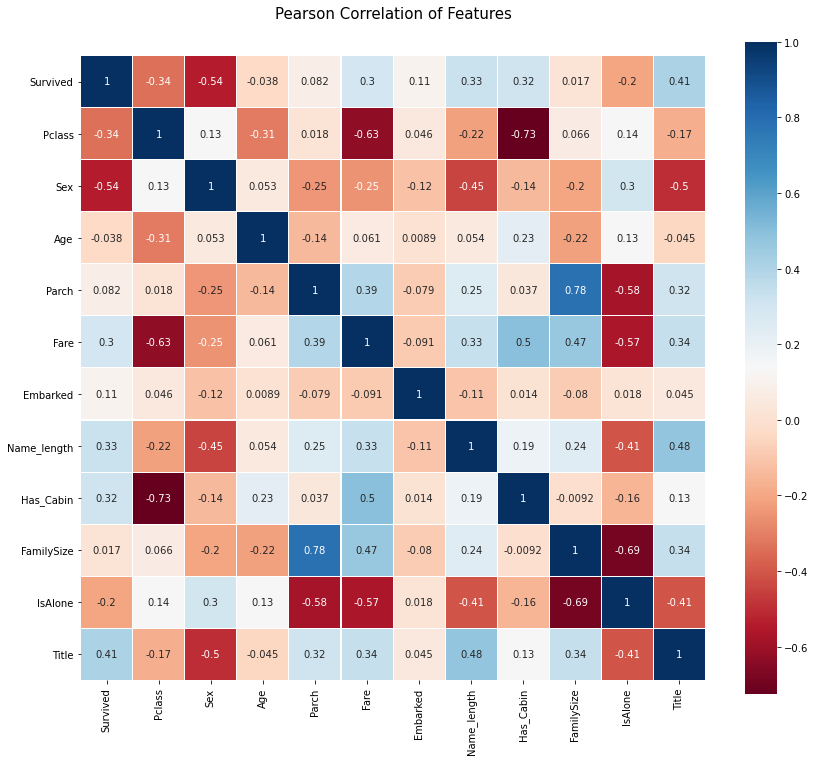

In [16]:
plt.figure(figsize=(14, 12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(train.astype(float).corr(), linewidths=0.1, vmax=1.0,
           square=True, annot=True, cmap='RdBu', linecolor='white')
plt.show()

#### Takeaway from the Plots
피어슨 상관관계 플롯을 보면 강한 상관관계를 갖는 플롯이 많지 않다는 것을 알 수 있습니다. 이는 트레이닝 셋에 불필요한 데이터가 없음을 의미하기 때문에 학습모델에 해당 feature들을 사용하려는 점에서 유용합니다.또한 각각의 feature들이 독특한 정보들을 준다는 점에서 기쁩니다. 가장 상관관계가 있는 두 feature는 FamilySize와 Parch입니다. 이 연습의 목적을 위해 두 변수를 그대로 두겠습니다.

#### Pairplots
데이터의 분포를 알아보기 위해 pairplot을 그려보겠습니다. 다시 한번 Seborn을 사용할 것입니다.

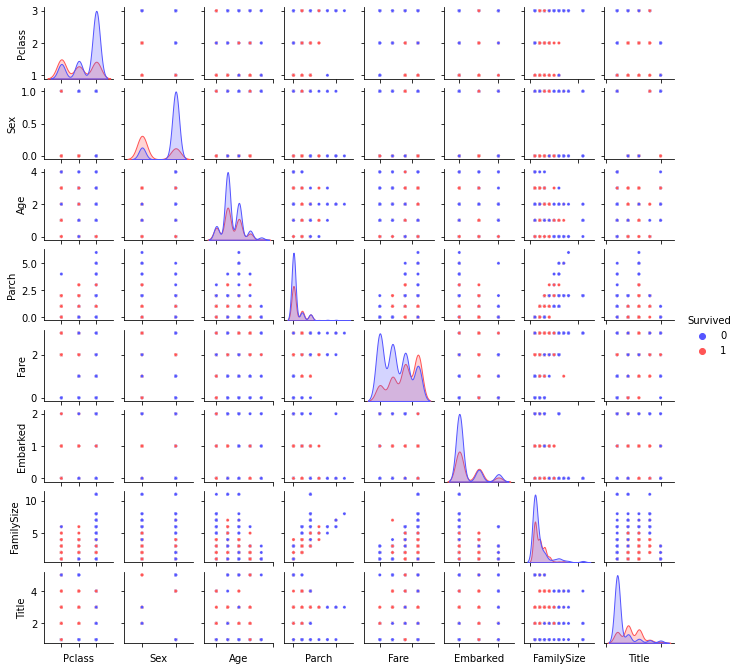

In [17]:
g = sns.pairplot(train[['Survived', 'Pclass', 'Sex', 'Age', 'Parch', 'Fare', 'Embarked', 'FamilySize', 'Title']],
                hue='Survived', palette='seismic', size=1.2, diag_kind='kde', diag_kws=dict(shade=True), plot_kws=dict(s=10))
g.set(xticklabels=[])

### 4. Ensembling & Stacking models
feature engineering과 formatting을 빠르게 지나왔고, 이제 이 노트북의 핵심 파트로 왔습니다. 스태킹 앙상블을 만들어봅시다.

#### Helpers via Python Classes
좀더 편하게 작업하기 위해 몇 가지 파이썬의 클래스들을 호출합니다. 클래스는 객체 지향 프로그래밍과 함께 사용됩니다. 즉, 클래스는 객체를 생성하기 위한 코드나 프로그램을 확장하는데 도움이 되며, 해당 클래스에 함수와 메소드를 구현합니다.  

다음 코드는 모든 Sklearn 분류기에 공통적으로 내장된 함수를 확장할 수 있게 하는 SklearnHelper 클래스에 대한 내용입니다. 

In [18]:
ntrain = train.shape[0]
ntest = test.shape[0]
SEED = 0
NFOLDS = 5
kf = KFold(n_splits=NFOLDS, random_state=SEED)

# Sklearn 분류기를 확장하기 위한 클래스
class SklearnHelper(object):
    def __init__(self, clf, seed=0, params=None):
        params['random_state'] = seed
        self.clf = clf(**params)
    
    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)
    
    def predict(self, x):
        return self.clf.predict(x)
    
    def fit(self, x, y):
        return self.clf.fit(x, y)
    
    def feature_importances(self, x, y):
        print(self.clf.fit(x, y).feature_importances_)

파이썬에서 클래스나 객체를 만들어본 적이 없는 사람들을 위해 위에 주어진 코드를 설명해보려 합니다. 기본 분류기를 만들 때 오로지 Sklearn 라이브러리에 있는 모델만 사용할 것이고, 따라서 그것에 대한 클래스만 확장할 것입니다.  

**def init:**  
클래서 기본 생성자를 호출하기 위한 파이썬의 표준입니다. 객체(분류기)를 만들고자 할 때, clf(sklearn의 분류기), seed(random seed), params(분류기의 파라미터)를 입력해야 합니다.  

나머지 코드들은 상응하는 sklearn 분류기 내부의 메소드를 호출하는 단순한 메소드들입니다. 근본적으로 다양한 Sklearn 분류기들을 확장하여 스태커에 다양한 학습자들을 구현할 때 같은 코드를 계속 반복해서 작성하는 작업을 줄이기 위해 만든 wrapper 클래스입니다.

#### Out-of-Fold Predictions
도입 부분에서 언급했던 것처럼, 스태킹은 2단계 모델을 학습하기 위한 input으로 기본 분류기들의 예측을 사용합니다. 그러나 단순히 트레이닝 데이터 전체에 대한 기본 모델을 학습하고 전체 테스트 셋에 대한 예측을 생성한 후 2단계 훈련을 위해 모델들을 출력할 수는 없습니다. 이미 기본 모델의 예측에 테스트 셋을 봤을 때, 이 예측을 제공하면 과적합될 위험이 있습니다.  

*numpy.zeros와 달리 numpy.empty는 어레이의 값들을 0으로 초기화하지 않아서 더 빠름

In [19]:
def get_oof(clf, x_train, y_train, x_test):
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))
    oof_test_skf = np.empty((NFOLDS, ntest))
    
    for i, (train_index, test_index) in enumerate(kf.split(x_train)):
        x_tr = x_train[train_index]
        y_tr = y_train[train_index]
        x_te = x_train[test_index]
        
        clf.train(x_tr, y_tr)
        
        oof_train[test_index] = clf.predict(x_te)
        oof_test_skf[i, :] = clf.predict(x_test)
    
    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)

### 5. Generating our Base First-Level Models
우리의 1단계 분류에 사용할 다섯 개의 학습 모델들을 준비해봅시다. 이 모델들은 Sklearn 라이브러리를 통해 쉽게 호출할 수 있습니다.  

1. Random Forest classifier (랜덤포레스트)
2. Extra Trees classifier (익스트림랜덤트리)
3. AdaBoost classifier (에이다부스트)
4. Gradient Boosting classifier (그레디언트부스팅)
5. Support Vector Machine (서포트벡터머신)

#### Parameters
**n_jobs**: 훈련 과정에서 사용될 코어의 개수, -1로 설정 시 모든 코어 사용  
**n_estimators**: 학습 모델의 분류 트리 개수, 기본값은 10  
**max_depth**: 트리의 최대 깊이, 또는 확장해야 하는 노드의 크기, 너무 높은 값으로 설정하면 트리의 깊이가 너무 깊어지기 때문에 과적합될 위험이 있음  
**verbose**: 학습 과정에 대한 텍스트 결과 출력을 조절, 0은 텍스트 출력x, 3은 모든 반복에 트리 학습 절차가 출력됨  

자세한 사항은 [Sklearn 사이트](https://scikit-learn.org/stable/)를 참조하세요.

In [20]:
# 파라미터 입력
# Random Forest 파라미터
rf_params = {
    'n_jobs':-1,
    'n_estimators':500, 
    'warm_start':True,
#     'max_features':0.2,
    'max_depth':6,
    'min_samples_leaf':2,
    'max_features':'sqrt',
    'verbose':0
}
# Extra Trees 파라미터
et_params = {
    'n_jobs':-1,
    'n_estimators':500,
#     'max_fatures':0.5,
    'max_depth':8,
    'min_samples_leaf':2,
    'verbose':0
}
# AdaBoost 파라미터
ada_params = {
    'n_estimators':500,
    'learning_rate':0.75
}
# Gradient Boosting 파라미터
gb_params = {
    'n_estimators':500,
#     'max_features':0.2,
    'max_depth':5,
    'min_samples_leaf':2,
    'verbose':0
}
# Support Vector Classifier 파라미터
svc_params = {
    'kernel':'linear',
    'C':0.025
}

OOP 프레임워크 내 객체와 클래스에 대해서 언급했기 때문에, 이제 사전에 정의한 SklearnHelper 클래스를 통해 5개의 학습 모델들을 나타내는 5개의 객체를 만들어봅시다.

In [21]:
# 5개의 모델들을 나타내는 5개의 객체 생성
rf = SklearnHelper(clf=RandomForestClassifier, seed=SEED, params=rf_params)
et = SklearnHelper(clf=ExtraTreesClassifier, seed=SEED, params=et_params)
ada = SklearnHelper(clf=AdaBoostClassifier, seed=SEED, params=ada_params)
gb = SklearnHelper(clf=GradientBoostingClassifier, seed=SEED, params=gb_params)
svc = SklearnHelper(clf=SVC, seed=SEED, params=svc_params)

#### Creating NumPy arrays out of our train and test sets
첫 번째 기본 모델 층을 만들었습니다. 이제 원래 데이터프레임에서 NumPy array를 만들어 분류기에 입력할 트레이닝 데이터와 테스트 데이터를 준비할 수 있습니다.  

*배열.ravel() : 다차원 배열을 1차원 배열로 변환

In [22]:
# 모델에 입력할 트레이닝, 테스트, 타겟 데이터의 NumPy array 생성
y_train = train['Survived'].ravel()
train.drop(['Survived'], axis=1, inplace=True)
x_train = train.values
x_test = test.values

#### Output of the First level Predictions
5개의 기본 분류기에 트레이닝 데이터와 테스트 데이터를 입력하고, 1단계 예측을 만들기 위해 앞에서 정의했던 Out-of-Fold 예측 함수를 사용하겠습니다. 다음 코드는 실행되는데 시간이 조금 걸립니다.

In [23]:
# OOF 트레이닝, 테스트 예측 생성
# Extra Trees
et_oof_train, et_oof_test = get_oof(et, x_train, y_train, x_test)
# Random Forest
rf_oof_train, rf_oof_test = get_oof(rf, x_train, y_train, x_test)
# AdaBoost
ada_oof_train, ada_oof_test = get_oof(ada, x_train, y_train, x_test)
# Gradient Boost
gb_oof_train, gb_oof_test = get_oof(gb, x_train, y_train, x_test)
# Support Vector Classifier
svc_oof_train, svc_oof_test = get_oof(svc, x_train, y_train, x_test)

print('Training is complete')

Training is complete


#### Feature importances generated from the different classifiers
1단계 분류기를 학습시켰으니 이제 Sklearn 모델들의 훌륭한 기능들을 활용할 수 있습니다. 바로 매우 간단한 코드로 트레이닝 셋과 테스트 셋의 다양한 feature들에 대한 중요도를 확인하는 것입니다.  

Sklearn 문서에 따르면, 대부분의 분류기들은 **.feature_importances_**를 입력하기만 하면 feature의 중요도를 리턴하는 속성이 내장되어 있습니다. 따라서 우리는 앞에서 만든 함수를 통해 이 속성을 호출하고 feature 중요도를 나타내보겠습니다.

In [24]:
rf_feature = rf.feature_importances(x_train, y_train)
et_feature = et.feature_importances(x_train, y_train)
ada_feature = ada.feature_importances(x_train, y_train)
gb_feature = gb.feature_importances(x_train, y_train)

[0.12543694 0.19919756 0.03135257 0.02100794 0.07219384 0.02389282
 0.11034111 0.06481951 0.06625257 0.0133757  0.27212944]
[0.12128623 0.38132597 0.02576287 0.01706301 0.0564956  0.02803837
 0.04830905 0.08398888 0.04424176 0.02179272 0.17169553]
[0.034 0.01  0.014 0.06  0.036 0.01  0.698 0.014 0.052 0.004 0.068]
[0.08827154 0.01282299 0.05138062 0.01493999 0.04977618 0.02326427
 0.16813642 0.03923336 0.11436161 0.00596984 0.43184319]


feature 중요도를 할당하고 저장하는 방법을 아직 파악하지 못했기 때문에 위의 코드에서 값을 출력한 후 다음 Python 목록에 붙여넣겠습니다.

In [25]:
rf_features = [0.12444684, 0.1992726, 0.03415395, 0.02061815, 0.07210196, 0.02259669, 0.1075789, 0.06552609, 0.06910728, 0.01359387, 0.27100368]
et_features = [0.1178221, 0.37824429, 0.03105153, 0.01750477, 0.05532562, 0.02873246, 0.04724392, 0.08393697, 0.04464622, 0.02168516, 0.17380696]
ada_features = [0.032, 0.014, 0.016, 0.068, 0.04, 0.008, 0.686, 0.014, 0.05, 0.004, 0.068]
gb_features = [0.08634036, 0.01222881, 0.04897444, 0.01496732, 0.05301311, 0.0228918, 0.1776066, 0.03744085, 0.11033338, 0.00676652, 0.42943679]

Plotly 패키지를 통해 쉽게 시각화시키기 위해 위의 리스트로 데이터프레임을 만듭니다.

In [26]:
cols = train.columns.values
feature_dataframe = pd.DataFrame({
    'features':cols,
    'Random Forest feature importances':rf_features,
    'Extra Trees feature importances':et_features,
    'AdaBoost feature importances':ada_features,
    'Gradient Boost feature importances':gb_features
})

#### Interactive feature importances via Plotly scatterplots
이 시점에서 대화형 Plotly 패키지를 사용하겠습니다. 'Scatter'를 호출하여 다양한 분류기들의 feature 중요도 값을 산점도를 통해 시각화해봅시다.

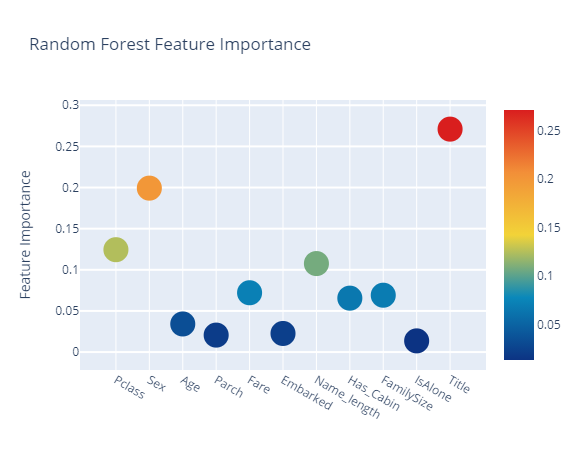

In [27]:
# Random Forest
trace = go.Scatter(
    y=feature_dataframe['Random Forest feature importances'].values,
    x=feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode='diameter',
        sizeref=1,
        size=25,
        color=feature_dataframe['Random Forest feature importances'].values,
        colorscale='Portland',
        showscale=True),
    text=feature_dataframe['features'].values
)
layout = go.Layout(
    autosize=True,
    title='Random Forest Feature Importance',
    hovermode='closest',
    yaxis=dict(
        title='Feature Importance',
        ticklen=5,
        gridwidth=2),
    showlegend=False
)
fig = go.Figure(data=[trace], layout=layout)
py.iplot(fig, filename='scatter2010')

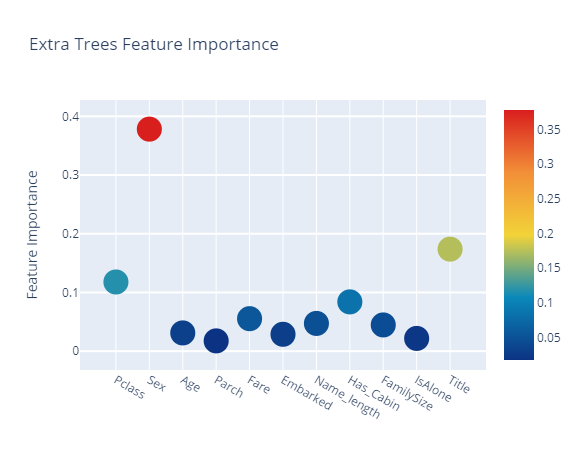

In [28]:
# Extra Trees
trace = go.Scatter(
    y=feature_dataframe['Extra Trees feature importances'].values,
    x=feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode='diameter',
        sizeref=1,
        size=25,
        color=feature_dataframe['Extra Trees feature importances'].values,
        colorscale='Portland',
        showscale=True),
    text=feature_dataframe['features'].values
)
layout = go.Layout(
    autosize=True,
    title='Extra Trees Feature Importance',
    hovermode='closest',
    yaxis=dict(
        title='Feature Importance',
        ticklen=5,
        gridwidth=2),
    showlegend=False
)
fig = go.Figure(data=[trace], layout=layout)
py.iplot(fig, filename='scatter2010')

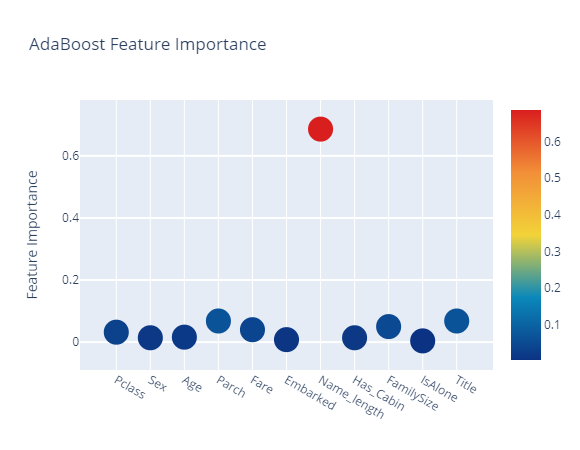

In [29]:
# AdaBoost
trace = go.Scatter(
    y=feature_dataframe['AdaBoost feature importances'].values,
    x=feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode='diameter',
        sizeref=1,
        size=25,
        color=feature_dataframe['AdaBoost feature importances'].values,
        colorscale='Portland',
        showscale=True),
    text=feature_dataframe['features'].values
)
layout = go.Layout(
    autosize=True,
    title='AdaBoost Feature Importance',
    hovermode='closest',
    yaxis=dict(
        title='Feature Importance',
        ticklen=5,
        gridwidth=2),
    showlegend=False
)
fig = go.Figure(data=[trace], layout=layout)
py.iplot(fig, filename='scatter2010')

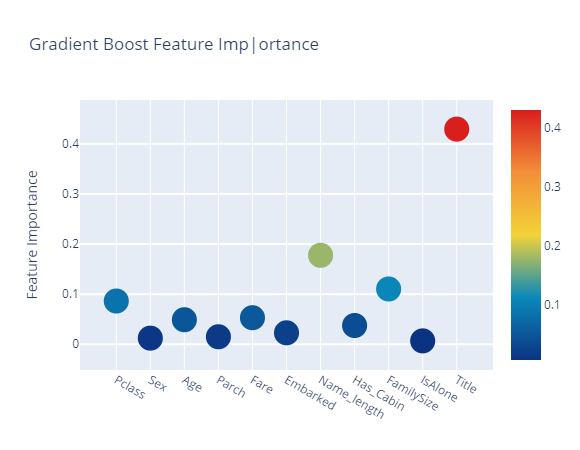

In [30]:
# Gradient Boost
trace = go.Scatter(
    y=feature_dataframe['Gradient Boost feature importances'].values,
    x=feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode='diameter',
        sizeref=1,
        size=25,
        color=feature_dataframe['Gradient Boost feature importances'].values,
        colorscale='Portland',
        showscale=True),
    text=feature_dataframe['features'].values
)
layout = go.Layout(
    autosize=True,
    title='Gradient Boost Feature Imp|ortance',
    hovermode='closest',
    yaxis=dict(
        title='Feature Importance',
        ticklen=5,
        gridwidth=2),
    showlegend=False
)
fig = go.Figure(data=[trace], layout=layout)
py.iplot(fig, filename='scatter2010')

모든feature 중요도의평균을 계산하고 feature importance 데이터프레임의 새로운 컬럼에 저장해보겠습니다.

In [31]:
# 평균값 컬럼 생성
feature_dataframe['mean'] = feature_dataframe.mean(axis=1)
feature_dataframe.head(3)

,features,Random Forest feature importances,Extra Trees feature importances,AdaBoost feature importances,Gradient Boost feature importances,mean
0,Pclass,0.124447,0.117822,0.032,0.086340,0.090152
1,Sex,0.199273,0.378244,0.014,0.012229,0.150936
2,Age,0.034154,0.031052,0.016,0.048974,0.032545


#### Plotly Barplot of Average Feature Importances
모든 분류기들의 평균 feature 중요도를 얻음으로써 다음과 같이 막대그래프로 나타낼 수 있습니다.

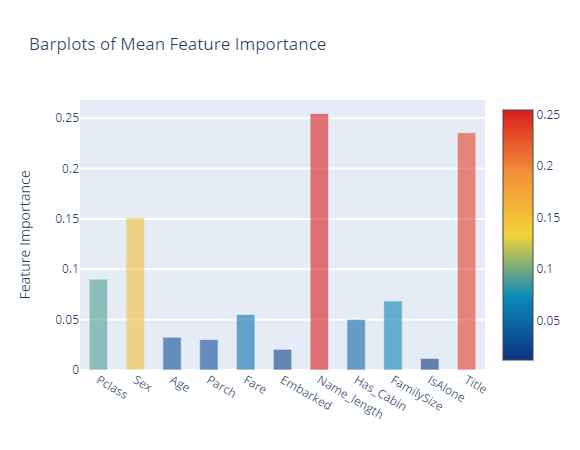

In [32]:
x = feature_dataframe['features'].values
y = feature_dataframe['mean'].values
data = [go.Bar(
    x=x, y=y, width=0.5,
    marker=dict(
        color=feature_dataframe['mean'].values,
        colorscale='Portland',
        showscale=True,
        reversescale=False),
    opacity=0.6
)]
layout = go.Layout(
    autosize=True,
    title='Barplots of Mean Feature Importance',
    hovermode='closest',
    yaxis=dict(
        title='Feature Importance',
        ticklen=5,
        gridwidth=2),
    showlegend=False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='bar-direct-labels')

### 6. Second-Level Predictions from the First-level Output

#### First-level output as new features
1단계 예측을 얻었으므로 그것이 본질적으로 다음 분류기의 트레이닝 데이터로 사용될 새로운 feature 셋이라고 생각할 수 있습니다. 다음 코드를 따라 1단계 예측에 대한 새로운 컬럼을 만들고 다음 분류기에 학습시킵니다.

In [33]:
base_predictions_train = pd.DataFrame({
    'RandomForest':rf_oof_train.ravel(),
    'ExtraTrees':et_oof_train.ravel(),
    'AdaBoost':ada_oof_train.ravel(),
    'GradientBoost':gb_oof_train.ravel()
})
base_predictions_train.head(3)

,RandomForest,ExtraTrees,AdaBoost,GradientBoost
0,0.0,0.0,0.0,0.0
1,1.0,1.0,1.0,1.0
2,1.0,0.0,1.0,1.0


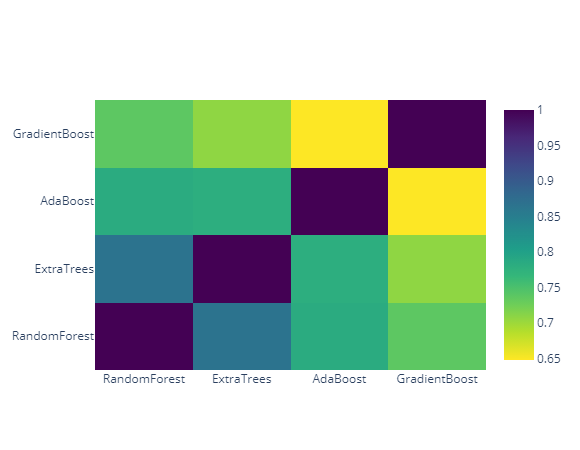

In [34]:
data = [go.Heatmap(
    z=base_predictions_train.astype(float).corr().values,
    x=base_predictions_train.columns.values,
    y=base_predictions_train.columns.values,
    colorscale='Viridis',
    showscale=True,
    reversescale=True
)]
py.iplot(data, filename='labelled-heatmap')

서로 관련이 없는 훈련된 모델들로 더 좋은 점수를 얻을 수 있다는 점에 대한 이야기가 많습니다. 

In [35]:
x_train = np.concatenate((et_oof_train, rf_oof_train, ada_oof_train, gb_oof_train, svc_oof_train), axis=1)
x_test = np.concatenate((et_oof_test, rf_oof_test, ada_oof_test, gb_oof_test, svc_oof_test), axis=1)

1단계 트레이닝과 테스트 예측을 x_train과 x_test에 연결하였고, 이제 2단계 학습 모델을 다뤄봅시다.

#### Second level learning model via XGBoost
상향된 트리 학습 모델을 위해 XGBoost 라이브러리를 사용합니다. 이것은 큰 규모의 상향된 트리 알고리즘을 최적화하기 위해 생성되었습니다. 해당 알고리즘에 대한 정보는 [문서](https://xgboost.readthedocs.io/en/latest/)를 통해 확인하십시오.

In [36]:
gbm = xgb.XGBClassifier(
    n_estimators=2000,
    max_depth=4,
    min_child_weight=2,
    gamma=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='binary:logistic',
    nthread=-1,
    scale_pos_weight=1
).fit(x_train, y_train)
predictions = gbm.predict(x_test)

[22:27:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


**max_dapth**: 트리의 깊이, 너무 큰 값은 과적합 가능성이 있음  
**gamma**: 트리의 leaf 노드에 추가 파티션을 만드는 데 필요한 최소 손실 감소, 값이 클수록 알고리즘의 보수성이 올라감  
**eta**: 과적합 방지를 위해 각 부스팅 단계에서 사용되는 step 크기 축소

#### Producing the submission file
1단계와 2단계 모델 모두 훈련과 학습을 마쳤습니다. 이제 타이타닉 대회에 제출하기 위한 적절한 형식으로 예측을 출력할 수 있습니다.

In [37]:
StackingSubmission = pd.DataFrame({
    'PassengerId':PassengerId,
    'Survived':predictions
})
StackingSubmission.to_csv('../data/titanic_4_submission.csv', index=False)